
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Course Project <br>
</div>


---



In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Section 1: Finding the Objects

In this part, we are going to implement functions to find and indicate samples of `template.png` in `input.jpg`. We will use correlation based methods to achieve this. You can see chapter 13.3 of the course reference for more information on how to do this. As a brief summary, there are four methods you can consider:


1.   **Cross Correlation**
2.   **Zero-mean Cross Correlation**
3.  **Sum of Squared Differences (SSD)**
4.  **Normalized Cross Correlation**

You are free to use any of the above methods (or a combination of them) you prefer (it is recommended to use Normalized Cross Correlation).



In [8]:
def iou(box1, box2):
    x1_a, y1_a, x2_a, y2_a = box1
    x1_b, y1_b, x2_b, y2_b = box2
    inter_x1 = max(x1_a, x1_b)
    inter_y1 = max(y1_a, y1_b)
    inter_x2 = min(x2_a, x2_b)
    inter_y2 = min(y2_a, y2_b)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area_a = (x2_a - x1_a) * (y2_a - y1_a)
    area_b = (x2_b - x1_b) * (y2_b - y1_b)
    union_area = area_a + area_b - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Non-maximum suppression using IoU
def nms(matches, iou_threshold=0.5):
    if not matches:
        return []
    matches = sorted(matches, key=lambda x: x['score'], reverse=True)
    selected = []
    while matches:
        best = matches[0]
        selected.append(best)
        matches = [m for m in matches[1:] if iou(best['box'], m['box']) < iou_threshold]
    return selected

In [4]:
def find_template(img: np.ndarray, template: np.ndarray):


Next function should draw a rectangle around the matches. Input is a masked image which is generated by the above function, indicating the matches.

In [5]:
def draw_bars(img: np.ndarray, template: np.ndarray, matches: list):



Now execute above functions for `input.jpg` and find matches for `temple.png`. Indicate the matches by drawing a rectangle around them and save the resulting image as `output1.jpg`. Your score for this part depends on the number of correct and incorrect matches.

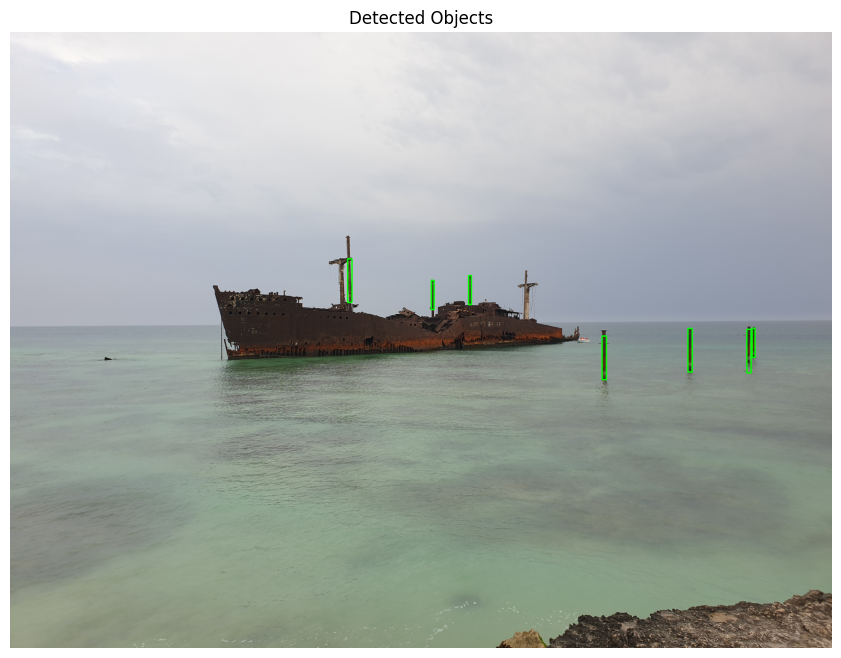

In [13]:
img_c = cv2.imread('input.jpg')
template_original = cv2.imread('cropped_template.jpg', 0)  # Grayscale
img = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY).astype(np.float32)

# Create a binary mask for the template
_, mask = cv2.threshold(template_original, 250, 255, cv2.THRESH_BINARY_INV)
template_masked = cv2.bitwise_and(template_original, template_original, mask=mask)

# Extended scales to detect smaller objects
scales = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 1.1, 0.55, 0.65, 0.75]
threshold = 0.45  # Lowered threshold
all_matches = []

# Precompute integral images for the entire image
integral_img = cv2.integral(img, sdepth=cv2.CV_64F)
integral_sq = cv2.integral(np.square(img), sdepth=cv2.CV_64F)

# Pyramid search over template scales
for s in scales:
    w_s = int(template_original.shape[1] * s)
    h_s = int(template_original.shape[0] * s)
    if w_s < 5 or h_s < 5:  # Skip if too small
        continue
    template_scaled = cv2.resize(template_masked, (w_s, h_s)).astype(np.float32)

    # Precompute template statistics
    T_sum = np.sum(template_scaled)
    T_sum_sq = np.sum(np.square(template_scaled))
    n_pixels = w_s * h_s
    T_mean = T_sum / n_pixels
    T_std = np.sqrt(max(0, T_sum_sq - n_pixels * T_mean**2))

    # Skip if template is uniform
    if T_std < 1e-10:
        continue

    # Compute cross correlation using filter2D
    cross_corr = cv2.filter2D(img, -1, template_scaled, anchor=(0, 0), borderType=cv2.BORDER_CONSTANT)
    cross_corr = cross_corr[:img.shape[0]-h_s+1, :img.shape[1]-w_s+1]

    # Compute window sums using integral images
    I_sum = (
            integral_img[:img.shape[0]-h_s+1, :img.shape[1]-w_s+1] +
            integral_img[h_s:, w_s:] -
            integral_img[:img.shape[0]-h_s+1, w_s:] -
            integral_img[h_s:, :img.shape[1]-w_s+1]
    )
    I_sum_sq = (
            integral_sq[:img.shape[0]-h_s+1, :img.shape[1]-w_s+1] +
            integral_sq[h_s:, w_s:] -
            integral_sq[:img.shape[0]-h_s+1, w_s:] -
            integral_sq[h_s:, :img.shape[1]-w_s+1]
    )

    # Compute NCC scores
    numerator = cross_corr - T_mean * I_sum
    I_var = np.maximum(0, I_sum_sq - np.square(I_sum) / n_pixels)
    I_std = np.sqrt(I_var)
    denominator = I_std * T_std
    ncc_map = np.zeros_like(numerator)
    valid_mask = denominator > 1e-10
    ncc_map[valid_mask] = numerator[valid_mask] / denominator[valid_mask]

    # Find locations above threshold
    loc = np.where(ncc_map >= threshold)
    for pt in zip(*loc[::-1]):  # pt is (x, y)
        box = (pt[0], pt[1], pt[0] + w_s, pt[1] + h_s)
        score = ncc_map[pt[1], pt[0]]
        all_matches.append({'box': box, 'score': score, 'scale': s})

# Apply NMS with adjusted IoU threshold
filtered_matches = nms(all_matches, iou_threshold=0.1)

# Draw rectangles around detected objects
for match in filtered_matches:
    box = match['box']
    margin = 10  # Adjust this value to increase/decrease size
    cv2.rectangle(img_c, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 5)

# Display results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB))
plt.title('Detected Objects')
plt.axis('off')
plt.show()

## Section 2: Image Completion

We will study and implement two methods for image completion.

### Method 1: Texture Synthesis

One way to complete a removed part of an image is to try regenerating the texture of its near pixels to cover it using texture synthesis. Texture synthesis is the process of constructing a large digital image from a small digital sample image by taking advantage of its structural content.

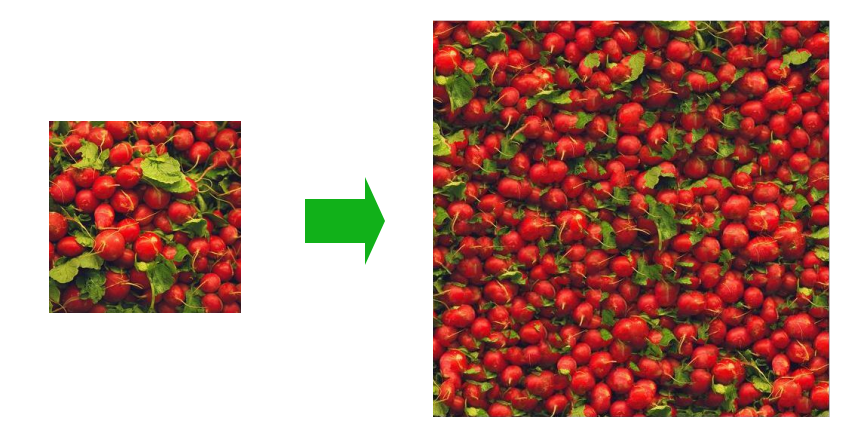

The method we are going to implement is based on the following paper:

 https://people.eecs.berkeley.edu/~efros/research/quilting/quilting.pdf

Complete the following function to apply texture synthesis to generate a larger image (with shape `result_shape`) with the given texture. `patch_size` indicated the size of the patch covered in each iteration. `overlap` is an integer indicating the number of overlaping pixels between any two patches.

**Note:** To avoid complicating this function, you may need to implement other helper functions and use them. implement them in the next cell.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize


def K_Smallest_Index(a, k):
  # Finding indexes of the K smallest elements of an array

  reshaped_a = np.reshape(a, (1, a.shape[0]*a.shape[1]), order = 'F')[0]
  sorted_a =  np.sort(reshaped_a)[0:k]
  index = []
  for i in range(k):
    index.append(np.where(reshaped_a == sorted_a[i])[0][0])
  index = np.array(index)
  return (index%a.shape[0], index//a.shape[0])


def Stitch_Vertical(template1, template2):
  # * find stitch location of two templates
  # * stitch template1 from right side to template2 from left side

  square_err = pow(np.float64(template1[:,:,0]) - np.float64(template2[:,:,0]),2)
  square_err += pow(np.float64(template1[:,:,1]) - np.float64(template2[:,:,1]),2)
  square_err += pow(np.float64(template1[:,:,2]) - np.float64(template2[:,:,2]),2)

  E = np.zeros(square_err.shape)
  E[0,:] = square_err[0,:]
  for i in range(1,E.shape[0]):
    for j in range(E.shape[1]):
      if j == 0:
        E[i][j] = square_err[i][j] + min(E[i-1][j], E[i-1][j+1])
      elif j == E.shape[1]-1:
        E[i][j] = square_err[i][j] + min(E[i-1][j], E[i-1][j-1])
      else:
        E[i][j] = square_err[i][j] + min(E[i-1][j-1], E[i-1][j], E[i-1][j+1])

  stitch = np.zeros(E.shape[0], dtype = np.int64)
  stitch[-1] = np.int64(np.where(E[-1,:] == np.min(E[-1,:]))[0][0])
  j = stitch[-1]
  for i in range(E.shape[0]-2, -1, -1):
    if j == 0:
      if E[i][j] <= E[i][j+1]:
        stitch[i] = j
      else:
        j = j + 1
        stitch[i] = j

    elif j == E.shape[1] - 1:
      if E[i][j] <= E[i][j-1]:
        stitch[i] = j
      else:
        j = j - 1
        stitch[i] = j
    else:
      temp = min(E[i][j-1], E[i][j], E[i][j+1])
      if temp == E[i][j-1]:
        j = j - 1
        stitch[i] = j
      elif temp == E[i][j]:
        stitch[i] = j
      else:
        j = j + 1
        stitch[i] = j
  return stitch


def Stitch_Horizontal(template1, template2):
  # * find stitch location of two templates
  # * stitch template1 from down side to template2 from up side

  square_err = pow(np.float64(template1[:,:,0]) - np.float64(template2[:,:,0]),2)
  square_err += pow(np.float64(template1[:,:,1]) - np.float64(template2[:,:,1]),2)
  square_err += pow(np.float64(template1[:,:,2]) - np.float64(template2[:,:,2]),2)


  E = np.zeros(square_err.shape)
  E[:,0] = square_err[:,0]
  for i in range(E.shape[0]):
    for j in range(1,E.shape[1]):
      if i == 0:
        E[i][j] = square_err[i][j] + min(E[i][j-1], E[i+1][j-1])
      elif i == E.shape[0]-1:
        E[i][j] = square_err[i][j] + min(E[i][j-1], E[i-1][j-1])
      else:
        E[i][j] = square_err[i][j] + min(E[i-1][j-1], E[i][j-1], E[i+1][j-1])


  stitch = np.zeros(E.shape[1], dtype = np.int64)
  stitch[-1] = np.int64(np.where(E[:,-1] == np.min(E[:,-1]))[0][0])
  i = stitch[-1]
  for j in range(E.shape[1]-2, -1, -1):
    if i == 0:
      if E[i][j] <= E[i+1][j]:
        stitch[j] = i
      else:
        i = i + 1
        stitch[j] = i

    elif i == E.shape[0] - 1:
      if E[i][j] <= E[i-1][j]:
        stitch[j] = i
      else:
        i = i - 1
        stitch[j] = i
    else:
      temp =  min(E[i-1][j], E[i][j], E[i+1][j])
      if temp == E[i-1][j]:
        i = i - 1
        stitch[j] = i
      elif temp == E[i][j]:
        stitch[j] = i
      else:
        i = i + 1
        stitch[j] = i
  return stitch

def Collision_Detection(stitch1, stitch2, template_size):
  # . Detect Collision of a vertical and a horizontal min cut in a template
  # . We use "and" logic in order to detect the collision of these min cuts
  # . If the collision is not detected then we shift one of the stitches for one step and then we find collision!

  S1 = np.zeros((template_size,template_size))
  S2 = np.zeros((template_size,template_size))

  for i in range(S1.shape[0]):
    S1[i, stitch1[i]] = 1
    S2[stitch2[i], i] = 1
  S = np.multiply(S1, S2)
  if np.max(S) != 0:
    loc = np.where(S == np.max(S))
    max_dist = np.array(loc[0]**2 + loc[1]**2).argmax()
    Collision = (loc[0][max_dist], loc[1][max_dist])
    return Collision

  else: #if collision is not detected
    S1 = np.zeros((template_size,template_size))
    for i in range(1, S1.shape[0]):   # Shift the stitch
      S1[i, stitch1[i-1]] = 1
    S = np.multiply(S1, S2)
    loc = np.where(S == np.max(S))
    max_dist = np.array(loc[0]**2 + loc[1]**2).argmax()
    Collision = (loc[0][max_dist], loc[1][max_dist])
    return Collision



def Texture_Synthesis(img, Texture_size, patch_size, overlap_size, randomness):
  # Creating syntehsized texture
  # input:
  # --- img: texture
  # --- Texture_size: size of the final image
  # --- patch_size: size of the patch we are about to merge
  # --- overlap_size: size of overlap between each two consecutive patches for stitching
  # --- randomness: an integer indicating the randomness of choosing the best patches

  Final_img_size = Texture_size

  patch_rows = patch_size
  patch_cols = patch_size
  template_cols = overlap_size

  # calculate size of image respect to patch size and the user's defined size
  Synthesized_img_size = np.ceil((Final_img_size - patch_cols)/(patch_cols - template_cols))
  Synthesized_img_size = Synthesized_img_size*(patch_cols - template_cols) + patch_cols
  Synthesized_img_size = np.int64(Synthesized_img_size)

  Synthesized_img = np.zeros((Synthesized_img_size,Synthesized_img_size,3), dtype = np.uint8)

  # first patch location chosen randomly
  random_loc = np.random.randint(1, [img.shape[0] - patch_rows,
                                     img.shape[1] - patch_cols])

  patch = img[random_loc[0]:random_loc[0]+patch_rows,
          random_loc[1]:random_loc[1]+patch_cols,:]
  Synthesized_img[0:patch_rows, 0:patch_cols, :] = patch

  # Pointers used in order to don't lose our location in sythesized img
  Pointer_right = 0
  Pointer_down = 0
  Pointer_right = Pointer_right + patch_cols
  Pointer_down = Pointer_down + patch_rows

  # while we haven't reached to the end of one line
  while Pointer_right <= Synthesized_img.shape[1]:

    # template used for template matching
    template = patch[:,-template_cols-1:-1,:]

    res = cv2.matchTemplate(img[0:-patch_rows,0:-patch_rows,:], template, cv2.TM_SQDIFF)
    min_locs = K_Smallest_Index(res, randomness) #choose randomly between candidaties!
    temp = np.random.randint(1, randomness)
    loc = (min_locs[0][temp], min_locs[1][temp])

    # patch extracted from prior image
    nxt_patch = img[loc[0]:loc[0]+patch_rows,
                loc[1]:loc[1]+patch_cols,:]

    # the template from nxtpatch used for min cut
    nxt_template = nxt_patch[:,0:template.shape[1],:]

    # stitch location ...
    stitch = Stitch_Vertical(template, nxt_template)

    # the final patch with considering min cuts and so on
    overlap = np.zeros(template.shape, dtype = np.uint8)
    for i in range(stitch.shape[0]):
      overlap[i,0:stitch[i],:] = template[i,0:stitch[i],:]
      overlap[i,stitch[i]:,:] = nxt_template[i,stitch[i]:,:]

    # plcae "overlap" in synthesized image
    Synthesized_img[0:patch_rows,
    Pointer_right-template.shape[1]:Pointer_right,
    :] = overlap
    try:
      Synthesized_img[0:patch_rows,
      Pointer_right:Pointer_right+patch_cols-template.shape[1],
      :] = nxt_patch[:, template.shape[1]:, :]
    except:
      Synthesized_img[0:patch_rows,
      Pointer_right:,
      :] = nxt_patch[:,
           template.shape[1]:template.shape[1]+Synthesized_img.shape[1]-Pointer_right,
           :]

    Pointer_right = Pointer_right + patch_cols - template.shape[1]
    patch = nxt_patch

  # next patch have to be merged in the first of the new line
  Pointer_right = patch_cols # Reseting Pointers


  patch = Synthesized_img[Pointer_down-patch_rows:Pointer_down,
          Pointer_right-patch_cols:Pointer_right,:]

  # template used for template matching
  template = patch[-template_cols-1:-1,:,:]
  res = cv2.matchTemplate(img[0:patch_rows,0:patch_rows,:], template, cv2.TM_SQDIFF)
  min_locs = K_Smallest_Index(res, randomness)
  temp = np.random.randint(1, randomness)
  loc = (min_locs[0][temp], min_locs[1][temp])

  # patch extracted from prior image
  nxt_patch = img[loc[0]:loc[0]+patch_rows,
              loc[1]:loc[1]+patch_cols,:]
  nxt_template = nxt_patch[0:template.shape[0],:,:]


  stitch = Stitch_Horizontal(template, nxt_template)

  overlap = np.zeros(template.shape, dtype = np.uint8)
  for i in range(stitch.shape[0]):
    overlap[0:stitch[i],i,:] = template[0:stitch[i],i,:]
    overlap[stitch[i]:,i,:] = nxt_template[stitch[i]:,i,:]

  Synthesized_img[Pointer_down-template.shape[0]:Pointer_down,
  Pointer_right-template.shape[1]:Pointer_right,
  :] = overlap

  Synthesized_img[Pointer_down:Pointer_down+patch_rows-template.shape[0],
  Pointer_right-template.shape[1]:Pointer_right
  :] = nxt_patch[template.shape[0]:,:, :]

  # Now we have to find L in image
  while Pointer_down < Synthesized_img.shape[0]:
    while Pointer_right <= Synthesized_img.shape[1] - (patch_cols - template_cols):
      template = np.zeros((patch_rows, patch_cols, 3), dtype = np.uint8)
      template[0:template_cols,:,:] = Synthesized_img[Pointer_down-template_cols:Pointer_down,
                                      Pointer_right-template_cols:Pointer_right-template_cols+patch_cols,
                                      :]
      template[:,0:template_cols,:] = Synthesized_img[Pointer_down-template_cols:Pointer_down-template_cols+patch_rows,
                                      Pointer_right-template_cols:Pointer_right,
                                      :]

      # Mask used for template matching
      mask_template = np.ones(patch.shape, dtype=np.uint8)
      mask_template[template_cols:, template_cols:,:] = np.zeros((patch_cols-template_cols,patch_rows - template_cols, 3),dtype=np.uint8)
      res = cv2.matchTemplate(img, template, cv2.TM_SQDIFF, mask = mask_template)
      min_locs = K_Smallest_Index(res, randomness)
      temp = np.random.randint(1, randomness)
      loc = (min_locs[0][temp], min_locs[1][temp])
      nxt_patch = img[loc[0]:loc[0]+patch_rows,
                  loc[1]:loc[1]+patch_cols,:]


      stitch1 = Stitch_Vertical(template[:,0:template_cols],
                                nxt_patch[:,0:template_cols])

      stitch2 = Stitch_Horizontal(template[0:template_cols,:],
                                  nxt_patch[0:template_cols,:])

      collision = Collision_Detection(stitch1, stitch2, template_cols)

      overlap = nxt_patch.copy()
      for i in range(collision[0], patch_rows):
        overlap[i,0:stitch1[i],:] = template[i,0:stitch1[i],:]

      for i in range(collision[1], patch_cols):
        overlap[0:stitch2[i],i,:] = template[0:stitch2[i],i,:]

      overlap[0:collision[0],0:collision[1],:] = template[0:collision[0],0:collision[1],:]
      overlap[template_cols:,template_cols:,:] = nxt_patch[template_cols:,template_cols:,:]

      try:
        Synthesized_img[Pointer_down-template_cols:Pointer_down-template_cols+patch_rows,
        Pointer_right-template_cols:Pointer_right-template_cols+patch_cols,
        :] = overlap
      except:
        Synthesized_img[Pointer_down-template_cols:Pointer_down-template_cols+patch_rows,
        Pointer_right-template_cols:,
        :] = overlap[:,
             0:Synthesized_img.shape[1]-(Pointer_right-template_cols),
             :]


      Pointer_right = Pointer_right - template_cols + patch_cols

    # New Line texture synthesis Again!
    Pointer_right = patch_cols
    Pointer_down = Pointer_down - template_cols + patch_cols
    patch = Synthesized_img[Pointer_down-patch_rows:Pointer_down,
            Pointer_right-patch_cols:Pointer_right,:]
    template = patch[-template_cols-1:-1,:,:]
    res = cv2.matchTemplate(img[0:-patch_rows,0:-patch_rows,:], template, cv2.TM_SQDIFF)
    min_locs = K_Smallest_Index(res, randomness)
    temp = np.random.randint(1, randomness)
    loc = (min_locs[0][temp], min_locs[1][temp])
    nxt_patch = img[loc[0]:loc[0]+patch_rows,
                loc[1]:loc[1]+patch_cols,:]

    nxt_template = nxt_patch[0:template.shape[0],:,:]


    stitch = Stitch_Horizontal(template, nxt_template)


    overlap = np.zeros(template.shape, dtype = np.uint8)
    for i in range(stitch.shape[0]):
      overlap[0:stitch[i],i,:] = template[0:stitch[i],i,:]
      overlap[stitch[i]:,i,:] = nxt_template[stitch[i]:,i,:]

    Synthesized_img[Pointer_down-template.shape[0]:Pointer_down,
    Pointer_right-template.shape[1]:Pointer_right,
    :] = overlap
    if Pointer_down < Synthesized_img.shape[0]:
      Synthesized_img[Pointer_down:Pointer_down+patch_rows-template.shape[0],
      Pointer_right-template.shape[1]:Pointer_right
      :] = nxt_patch[template.shape[0]:,:, :]

  # Blurrimg Image to have a better texture synthesis!
  Final_img = cv2.GaussianBlur(Synthesized_img[0:Final_img_size,
                               0:Final_img_size,
                               :], (3,3), 0.5)
  return Final_img

Apply this function on `texture1.jpg`, `texture2.jpg` and `texture3.jpg` and save the results as `output-synthesis1.jpg`, `output-synthesis2.jpg` and `output-synthesis3.jpg`, respectively. Dimension of the results should be $2400 \times 2400$. You can choose `patch_size` and `overlap` properly to get the best result. Your score on this part depends on the quality of the results.

In [57]:
from PIL import Image

path = '/Users/raya/Desktop/Project/texture2.jpg'
img = cv2.imread(path)
Synthesized_img = Texture_Synthesis(img,
                                    Texture_size = 2400,
                                    patch_size = 200,
                                    overlap_size = 50,
                                    randomness = 50)
Final_img = Synthesized_img
cv2.imwrite('result.jpg', Final_img)
img = Image.open('result.jpg')


new_size = (2400,2400)
resized_img = img.resize(new_size)

output_path = 'output-synthesis2.jpg'

resized_img.save(output_path)


In [6]:
from PIL import Image
path = '/Users/raya/Desktop/Project/texture3.jpg'
img = cv2.imread(path)
Synthesized_img = Texture_Synthesis(img,
                                    Texture_size = 2500,
                                    patch_size = 180,
                                    overlap_size = 20,
                                    randomness = 50)
Final_img = Synthesized_img
cv2.imwrite('result.jpg', Final_img)
img = Image.open('result.jpg')


new_size = (2400,2400)
resized_img = img.resize(new_size)

output_path = 'output-synthesis3.jpg'

resized_img.save(output_path)

In [16]:
path = '/Users/raya/Desktop/Project/texture1.jpg'
img = cv2.imread(path)
Synthesized_img = Texture_Synthesis(img,
                                    Texture_size = 2400,
                                    patch_size = 120,
                                    overlap_size = 10,
                                    randomness = 60)
Final_img = Synthesized_img
cv2.imwrite('result.jpg', Final_img)
img = Image.open('result.jpg')


new_size = (2400,2400)
resized_img = img.resize(new_size)

output_path = 'output-synthesis1.jpg'

resized_img.save(output_path)

### Method 2: Patch Match

**Patch Match** is a method for image inpainting introduced in the following work:

Website: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/index.php

Paper: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/patchmatch.pdf


Implement the following function to apply patch match on image `A` from image `B`:

In [ ]:
# Your helper functions here

In [ ]:
def perform_patch_match(A, B, patch_size, iterations=4):
  # TODO: implement patch match
  pass

From `patchmatch-input.jpg`, remove the two boats (you can do it manually) and recover their background using patchmatch. Choose proper parameters to get the best possible result.

In [ ]:
# TODO: remove the boats

## Section 3: Removing Objects and Completing the Image

For the last part, we will use above functions to remove the detected objects from section 1 and complete the initial image.

First, Remove the matched objects from `input.jpg` and plot the result. You may do this by simply setting the intensity of the matched pixels to 0 (or anything else).

In [ ]:
# TODO: Remove Objects

Now, apply texture synthesis or patch match (or both) to complete the removed part of the image. Save the result as `output-complete.jpg`. Your score on this part depends on the qulity of the completed parts.

In [ ]:
# TODO: Complete the image